# Inteligencia Artificial. Examen Final

Instrucciones:
* Por favor, complete las tareas de este notebook. Deberá enviar este notebook, así como una versión en PDF, a la plataforma Univirtual.
* Para crear el PDF, vaya a Archivo > Descargar como. Puede exportar a PDF mediante Latex, o exportar a HTML y luego imprimir a PDF.
* Añada una explicación clara de su enfoque y una interpretación detallada de sus resultados para cada subpregunta. Para ello, utilice celdas Markdown.

* Añada a continuación los nombres de todos los miembros del equipo.

**Integrantes:**

1.   Integrante 1:
2.   Integrante 2:

# 1 Técnicas basadas en regiones para la segmentación de imágenes (3 puntos)


La segmentación de imágenes es el proceso de **asignar una etiqueta a cada píxel en una imagen** de modo que los píxeles con la misma etiqueta compartan ciertas características. Como consecuencia, se producen regiones cuyos píxeles tienen propiedades similares, por ejemplo: intensidad, color, textura o ubicación en la imagen. El resultado de la segmentación de imágenes puede ser:

* un conjunto de segmentos que cubren colectivamente toda la imagen (por ejemplo, umbralización),
* o un conjunto de contornos extraídos de la imagen (por ejemplo, detección de bordes).


<img src="./images/image-segmentation-example.png" width="550"/>

Conceptualmente, existen dos enfoques tradicionales para la segmentación de imágenes:

* **Segmentación de arriba hacia abajo (top-down)**, que considera que los píxeles del mismo objeto en la escena deben estar en la misma región segmentada.
* **Segmentación de abajo hacia arriba (bottom-up)**, que establece que los píxeles similares en la imagen deben estar en la misma región segmentada.


<center><img src="./images/bottom-up_top-down-segmentation.png" width="500"/>Imagen adaptada de <a href="myfootnote1">[1]</a></center>


Aquí ponemos el foco en los enfoques de segmentación de abajo hacia arriba. Los métodos que siguen este enfoque pueden agruparse en:

* **Técnicas basadas en contornos**, que intentan identificar las regiones de la imagen detectando sus contornos.
* **Técnicas basadas en regiones**, que agrupan píxeles que son similares entre sí.

En este notebook, cubriremos ambas familias de técnicas, comenzando con dos métodos populares basados en regiones:

* Expectation-Maximization


## Contexto del problema - Cuantización de color


<img src="./images/color-quantization.jpg" width="800"/>


La cuantización de color es el proceso de reducir el número de colores distintos en una imagen mientras se preserva su apariencia de color lo mejor posible. Tiene muchas aplicaciones, como la compresión de imágenes (por ejemplo, GIFs) o [content-based image retrieval](https://en.wikipedia.org/wiki/Content-based_image_retrieval).


Las técnicas de segmentación de imágenes pueden utilizarse para lograr la cuantización de color, ¡veamos cómo funciona!


## 1.2 Expectation-Maximization (EM)

**Expectation-Maximization (EM)** es la generalización del algoritmo K-means, donde cada clúster está representado por una distribución Gaussiana, parametrizada por una media y una matriz de covarianza, en lugar de solo un centroide. Es un *clustering suave* ya que no toma decisiones *duras* sobre si un píxel pertenece o no a un clúster, sino que calcula la probabilidad de que ese píxel pertenezca a cada clúster $C_j$, that is, $p(x|C_j) \sim N(\mu_j,\Sigma_j)$.  Esto implica que en cada iteración del algoritmo no solo se refina la media de cada clúster (como en K-means), sino también sus matrices de covarianza.

Antes de entrar en detalle sobre la teoría detrás de EM, vale la pena ver cómo se desempeña en el problema de la placa del auto. OpenCV proporciona una clase que implementa la funcionalidad necesaria para aplicar segmentación EM a una imagen, llamada [cv2.ml.EM](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html). Todos los métodos y parámetros están completamente detallados en la documentación, por lo que es una buena idea echarle un vistazo.


In [ ]:
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
cv2.setRNGSeed(5)

# Define parameters
n_clusters = 2
covariance_type = 0 # 0: covariance matrix spherical. 1: covariance matrix diagonal. 2: covariance matrix generic
n_iter = 10
epsilon = 0.2

# Create EM empty object
em = cv2.ml.EM_create()

# Set parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, n_iter, epsilon)
em.setClustersNumber(n_clusters)
em.setCovarianceMatrixType(covariance_type)
em.setTermCriteria(criteria)

# Read grayscale image
image = cv2.imread(images_path + "plate.jpg",0)

# Flatten image
flattened_img = image.reshape((-1,1))
flattened_img = np.float32(flattened_img)

# Apply EM
_, _, labels, _ = em.trainEM(flattened_img)

# Reshape labels to image size (binarization)
binarized = labels.reshape((image.shape))

# Show original image
plt.subplot(2,1,1)
plt.title("Binarized image")
plt.imshow(binarized, cmap="gray")

# --------------- Gaussian visualization ---------------

plt.subplot(2,1,2)
plt.title("Probabilities of the clusters")

# Get means and covs (for grayscale 1D both)
means = em.getMeans()
covs = em.getCovs()

# Get standard deviation as numPy array
sigmas = np.sqrt(covs)
sigmas = sigmas[:,0,0]

# Cast list to numPy array
means = np.array(means)[:,0]

# Plot Gaussians
x = np.linspace(0, 256, 100)
plt.plot(x, stats.norm.pdf(x, loc = means[0], scale = sigmas[0]))
plt.plot(x, stats.norm.pdf(x, loc = means[1], scale = sigmas[1]))
plt.legend(['Black Region', 'White Region'])

plt.show()

NameError: name 'matplotlib' is not defined

Como puedes ver, aunque en OpenCV **k-means** está implementado como un método y **EM** como una clase, ambos operan de forma similar. En el ejemplo anterior, estamos segmentando una placa de automóvil en dos clústeres, y **cada clúster está definido por una distribución Gaussiana** (una distribución Gaussiana para la región negra y otra para la región blanca). Esta es la base de EM, pero **¿cómo funciona?**

EM es un algoritmo iterativo que se divide en dos pasos principales:

* Primero, **inicializa la media y la matriz de covarianza de cada uno de los \$K\$ clústeres**. Típicamente, se eligen al azar (\$\mu\_j\$, \$\Sigma\_j\$) y \$P(C\_j)\$ (probabilidad a priori) para cada clúster \$j\$.
* Luego, se mantiene iterando realizando los pasos de Expectación-Maximización hasta que se cumpla algún criterio de parada (por ejemplo, cuando no ocurre ningún cambio en una iteración completa):

  1. **Paso de Expectación:** calcular las probabilidades de que cada punto pertenezca a cada clúster, es decir, \$p(C\_j|x\_i), \forall i \in \text{data}\$:

  $$
  P(C_j|x_i)=\frac{p(x_i|C_j)p(C_j)}{p(x_i)}=\frac{p(x_i|C_j)p(C_j)}{\sum_i p(x_i|C_j)p(C_j)}
  $$

  Se asigna \$x\_i\$ al clúster \$C\_j\$ con la mayor probabilidad \$P(C\_j|x\_i)\$.
  
  2\. **Paso de Maximización:** se reestiman los parámetros de los clústeres ((\$\mu\_j\$, \$\Sigma\_j\$) y \$p(C\_j)\$) para cada clúster \$j\$ conociendo los resultados del paso de expectación, lo que también se conoce como *Estimación de Máxima Verosimilitud (MLE)*:

  $$
  \mu_j=\frac{\sum_i p(C_j|x_i)x_i}{\sum_i p(C_j|x_i)} \\
  \Sigma_j = \frac{\sum_i p(C_j|x_i)(x_i-\mu_j)(x_i-\mu_j)^T}{\sum_i p(C_j|x_i)} \\
  p(C_j)=\sum_i p(C_j|x_i)p(x_i)=\frac{\sum_i p(C_j|x_i)}{N}
  $$

  *Nota que si no se dispone de otra información, se considera que las probabilidades a priori son igualmente probables.*


<img src="./images/em.gif" width="400" align="center">
<center><i>Ejemplo de una ejecución del algoritmo EM con dos clústeres, mostrando la evolución de sus distribuciones Gaussianas asociadas.</i></center>


¿No te recuerda al algoritmo K-means? **¿Cuál es la diferencia entre ellos?**

La principal diferencia es que **K-means utiliza la distancia euclidiana** para medir qué tan cerca está un punto de un clúster. En EM se utiliza una distancia en la que **cada dimensión se pondera** según la **matriz de covarianza** de cada clúster, lo que se conoce como **distancia de Mahalanobis**. Además, en K-means un punto de datos **pertenece o no** a un clúster, mientras que en EM un punto de datos tiene una **probabilidad mayor o menor** de pertenecer a un clúster. La siguiente tabla resume otras diferencias:


<table width="500px">
    <tr>
        <td style="text-align:center;"></td>
        <td style="text-align:center;"><b>K-means</b></td>
        <td style="text-align:center;"><b>EM</b></td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Representación del clúster</b></td>
        <td style="text-align:center;">Media</td>
        <td style="text-align:center;">Media y (co)varianza</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Inicialización del clúster</b></td>
        <td style="text-align:center;">Selección aleatoria de K medias</td>
        <td style="text-align:center;">Inicialización de K distribuciones Gaussianas <br />($\mu_j$, $\Sigma_j$) y $P(C_j)$</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Expectación:</b> <br /> Estimar el clúster de cada dato</td>
        <td style="text-align:center;">Asignar cada punto a la media más cercana</td>
        <td style="text-align:center;">Calcular $P(C_j|x_i)$</td>
    </tr>
    <tr>
        <td style="text-align:center;"><b>Maximización:</b> <br /> Reestimar los parámetros del clúster</td>
        <td style="text-align:center;">Calcular medias de los clústeres actuales</td>
        <td style="text-align:center;">Calcular nuevos ($\mu_j$, $\Sigma_j$) y $P(C_j)$ para cada clúster $j$</td>
    </tr>
</table>


Si aún tienes curiosidad sobre EM, puedes encontrar [aquí](https://www.youtube.com/watch?v=REypj2sy_5U) una explicación más detallada.


#### <font color="orange">Cápsula OpenCV</font>

Volviendo al código, al trabajar con EM debemos especificar un tipo de matriz de covarianza utilizando [`em.setCovarianceMatrixType()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#a8b383c62697eac9a972931674790f6cd). Además, cuando aplicas [`em.trainEM()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#a5a6a7badbc0c85a8c9fa50a41bf1bcd2), este no devuelve el centroide de los clústeres; es posible obtenerlos llamando a [`em.getMeans()`](https://docs.opencv.org/3.4/d1/dfb/classcv_1_1ml_1_1EM.html#acec62dd55c06711c81d741c2d96603d1).


### **<span style="color:green"><b><i>TAREA 2: Cuantización de color con el espacio de color YCrCb</i></b></span>**

En el siguiente ejemplo, la cuantización de color se realiza utilizando el espacio de color YCrCb (más información sobre este espacio en el apéndice 2) en lugar de RGB. De este modo, la cuantización de color se aplica solo a las dos bandas de color, omitiendo la banda en escala de grises. ¡Veamos cómo funciona!

**¿Qué hacer?** Entender y probar el siguiente código.


In [ ]:
# Assignment 2
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
cv2.setRNGSeed(5)

# Define parameters

n_clusters = 3 # Don't modify this parameter for this exercise

covariance_type = # 0: Spherical covariance matrix. 1: Diagonal covariance matrix. 2: Full covariance matrix
n_iter = 10
epsilon = 0.2

# Create EM empty object


# Set parameters


# Read color image


# Convert to YCrCb


# Take color bands (2 lasts)


# Flatten image


# Apply EM


# Colour resultant labels


# Reshape to original shape


# Merge original first band with quantized color bands


# Cast to unsigned data dype


# Reconvert to RGB


# Show original image


# Show resultant image


### <font color="blue"><b><i>Reflexionando sobre ello (2)</i></b></font>

Una vez que hayas entendido el código anterior, **responde las siguientes preguntas:**

* ¿Por qué los resultados obtenidos son tan buenos usando solo 3 clústeres?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>¡Tu respuesta aquí!</i></p>

* ¿Qué compresión sería mejor en términos de espacio en memoria: una compresión a 16 colores en una imagen RGB o una compresión a 4 colores en una imagen YCrCb?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>¡Tu respuesta aquí!</i></p>


### Profundizando en las matrices de covarianza

Existen 3 tipos de matrices de covarianza: **covarianzas esféricas**, **covarianzas diagonales** o **covarianzas completas**:


<img src="./images/ellipses.png" width="700" align="center">




### **<span style="color:green"><b><i>TAREA 3: Visualizando los clústeres con EM</i></b></span>**

A continuación, tienes un código para visualizar los clústeres en el espacio de color YCrCb utilizando EM.

**¿Qué hacer?** Ejecuta el ejemplo anterior modificando el tipo de covarianza en el algoritmo EM y visualiza los cambios utilizando el siguiente código.


In [ ]:
# Assignment 3
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

# Get means (2D) and covariance matrices (2x2)
means = np.array(em.getMeans())
covs = np.array(em.getCovs())

# Create figure
fig, ax = plt.subplots()
plt.axis([16, 240, 16, 240])

# Get points contained in each cluster
cluster_1 = np.any(color_bands == np.unique(res,axis=0)[0,:],axis=2)
cluster_2 = np.any(color_bands == np.unique(res,axis=0)[1,:],axis=2)
cluster_3 = np.any(color_bands == np.unique(res,axis=0)[2,:],axis=2)
cluster_1 = image[cluster_1]
cluster_2 = image[cluster_2]
cluster_3 = image[cluster_3]

# Plot them
plt.plot(cluster_1[:,1],cluster_1[:,2],'go')
plt.plot(cluster_2[:,1],cluster_2[:,2],'ro')
plt.plot(cluster_3[:,1],cluster_3[:,2],'bo')

# Plot ellipses representing covariance matrices
PlotEllipse(fig, ax, np.vstack(means[0,:]), covs[0,:,:], 2, color='black')
PlotEllipse(fig, ax, np.vstack(means[1,:]), covs[1,:,:], 2, color='black')
PlotEllipse(fig, ax, np.vstack(means[2,:]), covs[2,:,:], 2, color='black')

fig.canvas.draw()


### <font color="blue"><b><i>Reflexionando sobre ello (3)</i></b></font>

**Responde las siguientes preguntas** sobre cómo funciona el clustering en EM:

* ¿Cuáles son las diferencias entre cada tipo de covarianza?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>¡Tu respuesta aquí!</i></p>

* ¿Qué tipo de covarianza hace que EM sea equivalente a k-means?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>¡Tu respuesta aquí!</i></p>



### **<span style="color:green"><b><i>TAREA 4: Aplicando EM considerando diferentes espacios de color</i></b></span>**

¡Es hora de demostrar lo que has aprendido sobre **EM** y **espacios de color**!

**¿Cuál es tu tarea?** Se te pide que **compares la cuantización de color en un espacio de color RGB y en un espacio de color YCrCb**.

Para ello:

* aplica el algoritmo Expectation-Maximization a `malaga.png` utilizando 4 clústeres (colores) tanto en la imagen en espacio RGB como en la imagen en espacio YCrCb,
* y muestra ambos resultados junto con la imagen original.


<font color='blue'>**Salida esperada:**  </font>

<img src="images/exercise2.png" width="800"/>

In [ ]:
# Assignment 4
matplotlib.rcParams['figure.figsize'] = (15.0, 12.0)
cv2.setRNGSeed(5)

# Define parameters
n_clusters = 4
covariance_type = 2 # 0: covariance matrix spherical. 1: covariance matrix diagonal. 2: covariance matrix generic
n_iter = 10
epsilon = 0.2

# Create EM empty objects


# Set parameters


# Read image


# Convert image to RGB


# Convert image to YCrCb


# Flatten RGB image


# Flatten color bands of YCrCb image


# Apply EM and get centers of clusters


# Colour resultant labels


# Reshape to original shape


# Merge original first band with quantized color bands for YCrCb image


# Cast YCrCb image to unsigned data dype


# Reconvert YCrCb image back to RGB


# Show original image


# Show resultant quantization using RGB color space


# Show resultant quantization using YCrCb color space


## Conclusión

¡Felicidades por haber completado este trabajo! Has aprendido:

* cómo funciona el clustering k-means y cómo utilizarlo,
* cómo se desempeña el algoritmo EM y cómo emplearlo,
* cómo realizar cuantización de color y la importancia de los espacios de color en este contexto, y
* algunos conceptos básicos sobre compresión de imágenes.

### Extra

Has utilizado YCrCb en este notebook porque ya estabas familiarizado con él. La verdad es que, en temas de cuantización de color, [Lab color space](https://en.wikipedia.org/wiki/CIELAB_color_space) es comúnmente utilizado.  

Busca información en internet sobre el espacio de color Lab y luego  **responde las siguientes preguntas:**:

- ¿Cómo funciona el espacio de color Lab?
- ¿Por qué se utiliza típicamente para la cuantización de color?

# 2. Tarea: Clasificación de Imágenes (7 puntos)

En este ejercicio práctico resolverás un problema de clasificación de imágenes utilizando modelos profundos.

Los objetivos de esta tarea son:

* Desarrollar destreza en el uso de Keras para entrenar redes neuronales (NNs).
* Poner en práctica conocimientos generales de Machine Learning para optimizar los parámetros y la arquitectura de una red neuronal densa de avance directo (ffNN), en el contexto de un problema de visión por computadora.
* Utilizar redes neuronales especialmente concebidas para analizar imágenes. Diseñar y optimizar los parámetros de una red neuronal convolucional (cNN).
* Mejorar el rendimiento de una red neuronal mediante regularización y procesamiento de los datos a través de la red.


## A) Dense feed forward model (1.5 puntos)

Diseña y entrena una **ffNN** que resuelva el problema de clasificación planteado en la base de datos **Cifar-10**.

Como punto de partida en este proyecto, puedes utilizar el modelo proporcionado en los materiales del curso.

Debes mejorar los resultados obtenidos en los archivos de configuración de la red inicial. Para ello, debes decidir sobre:

* El número de capas y el número de unidades en cada capa.
* El algoritmo de optimización y los parámetros para entrenar la red.
* Revisar la evolución de estos parámetros durante la optimización y decidir cuándo detener el entrenamiento.


In [ ]:
# Load CIFAR-10 data set
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


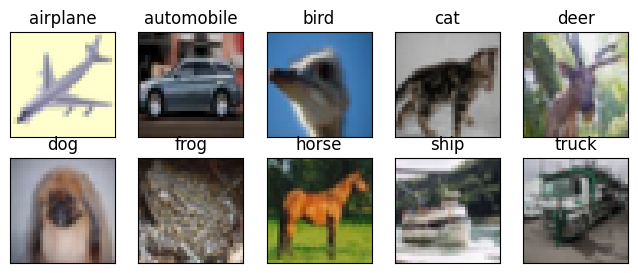

In [ ]:
# Show examples from each class
import numpy as np
import matplotlib.pyplot as plt

num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    rnd_img = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[rnd_img,::], (0, 1, 2))
    plt.imshow(im)
plt.show()

In [ ]:
# Data pre-processing
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
# Multilayer Perceptrons (MLPs)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3)))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        30,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.2819 - loss: 2.0140 - val_accuracy: 0.3670 - val_loss: 1.8058
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3621 - loss: 1.8217 - val_accuracy: 0.3646 - val_loss: 1.7948
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3693 - loss: 1.8089 - val_accuracy: 0.3788 - val_loss: 1.8144
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3774 - loss: 1.7876 - val_accuracy: 0.3927 - val_loss: 1.7490
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3886 - loss: 1.7627 - val_accuracy: 0.3731 - val_loss: 1.7957
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3905 - loss: 1.7599 - val_accuracy: 0.3793 - val_loss: 1.7690
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3918 - loss: 1.7547 - val_accuracy: 0.3644 - val_loss: 1.8089
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3984 - loss: 1.7485 - val_accuracy: 0.

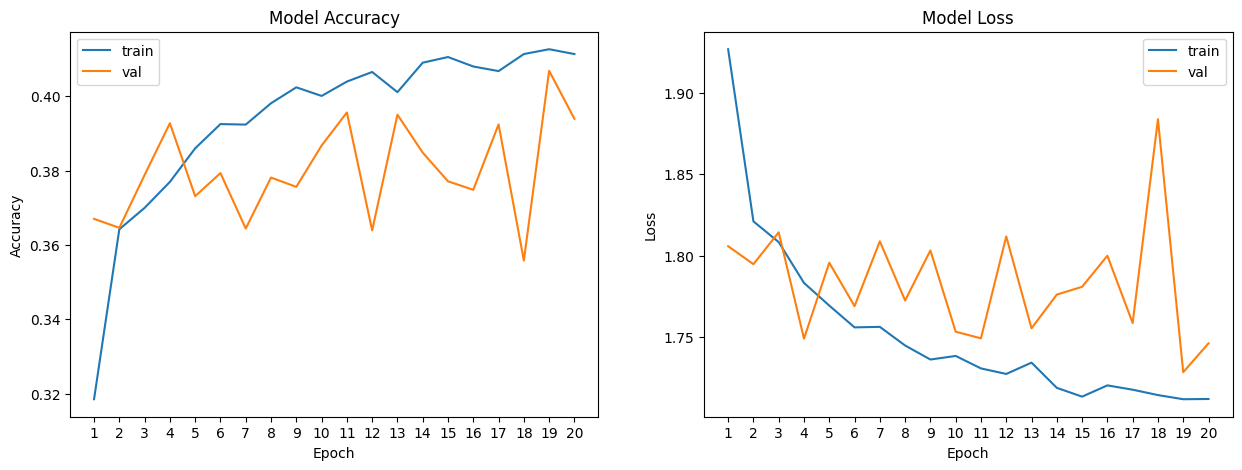

Training MLP took 43.77811145782471 seconds


In [ ]:
# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## B) Convolutional model (1.5 puntos)

Aquí experimentamos con **cNNs**, un tipo especial de red neuronal concebida para analizar imágenes. Utiliza **cNNs** para diseñar un nuevo modelo que supere los resultados de clasificación previos obtenidos en el conjunto de datos **Cifar-10**.


In [ ]:
# Convolutional Neural Network (CNN)
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

model = Sequential()
model.add(Conv2D(filters=48, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=96, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=192, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(1, 1), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(filters=10, kernel_size=(4, 4), padding='valid'))
model.add(Flatten())
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 48)     │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 96)     │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 10)       │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,298 (860.54 KB)

 Trainable params: 220,298 (860.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2755 - loss: 2.0364 - val_accuracy: 0.3640 - val_loss: 1.8188
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3580 - loss: 1.8356 - val_accuracy: 0.3574 - val_loss: 1.8247
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3763 - loss: 1.7922 - val_accuracy: 0.3734 - val_loss: 1.7794
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3818 - loss: 1.7756 - val_accuracy: 0.3759 - val_loss: 1.7984
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3877 - loss: 1.7681 - val_accuracy: 0.3775 - val_loss: 1.7819
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3892 - loss: 1.7571 - val_accuracy: 0.3906 - val_loss: 1.7366
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3944 - loss: 1.7485 - val_accuracy: 0.3724 - val_loss: 1.7979
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3958 - loss: 1.7456 - val_accuracy: 0.

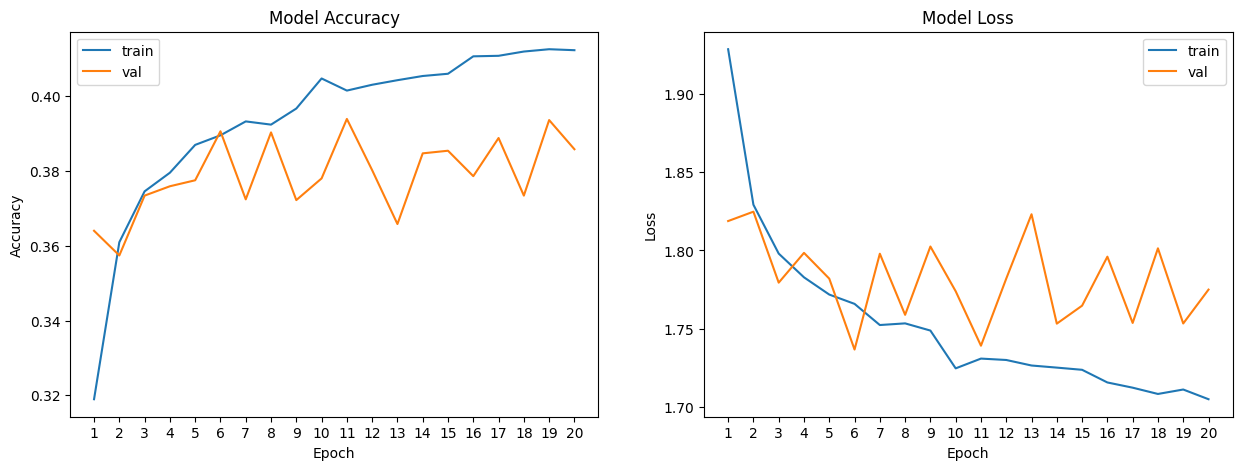

Training MLP took 40.51060390472412 seconds


In [ ]:
# Training
import time
start = time.time()
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test))
end = time.time()

loss, acc = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## C) Mejora de la Performance (2 puntos)

### Ejercicio C.1: Regularización

* Explora diferentes formas de regularizar tu modelo

  * Prueba añadiendo *dropout* después de cada capa de *MaxPooling* y de cada capa *Dense*.

    * ¿Cuáles son buenas tasas de *Dropout*? Prueba con una tasa fija de *Dropout* o aumenta las tasas en las capas más profundas.
  * Prueba la normalización por lotes (*batch normalization*) junto con *Dropout*

    * Piensa en qué lugares tendría sentido aplicar *batch normalization*
* Grafica e interpreta las curvas de aprendizaje


### Ejercicio C.2: Data Augmentation

* Realiza aumento de imágenes (rotación, desplazamiento, cizalladura, zoom, volteo, etc.). Puedes utilizar **ImageDataGenerator** para esto.
* ¿Cuál es el efecto? ¿Cuál es el efecto con y sin *Dropout*?
* Grafica e interpreta las curvas de aprendizaje.


### Ejercicio C.3: Mejoras Finales

Mejora el rendimiento de tus redes neuronales regularizando y preprocesando los datos a través de la red. Utiliza cualquier combinación de técnicas de regularización o procedimientos de procesamiento de datos para mejorar el rendimiento de tu **ffNN** y **cNN**.


## D) Reporte (1.5 puntos)

Redacta un informe describiendo:

* el problema (brevemente);
* las arquitecturas finales de las redes y el rendimiento final (precisión y pérdida) obtenido con los cuatro modelos (**ffNN**, **ffNN+mejora**, **cNN**, **cNN+mejora**) en los conjuntos de datos de entrenamiento y prueba;
* gráficos de la evolución de los costos y del rendimiento de clasificación en ambos conjuntos de datos para cada arquitectura;
* el proceso que has seguido para llegar a tu solución final;
* discute tus resultados.


## References

<a name="myfootnote1">[1]</a>: Borenstein, Eran, Eitan Sharon, and Shimon Ullman. [Combining top-down and bottom-up segmentation.](http://www.wisdom.weizmann.ac.il/~vision/courses/2006_2/papers/recog_seg/Borenstein%20combining%20top-down%20and%20bottom-up%20segmentation.pdf). IEEE Conference on Conference on Computer Vision and Pattern Recognition Workshop, 2004.